In [25]:
%load_ext autoreload
%autoreload 2

# Core imports
from causalab.tasks.MCQA.causal_models import positional_causal_model
from causalab.tasks.MCQA.counterfactuals import different_symbol
from causalab.tasks.MCQA.token_positions import create_token_positions

# Neural framework imports
from causalab.neural.pipeline import LMPipeline

# Causal imports
from causalab.causal.causal_utils import save_counterfactual_examples

# Standard imports
import torch
import os

# Setup
causal_model = positional_causal_model

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "meta-llama/Llama-3.2-1B-Instruct"
pipeline = LMPipeline(
    model_name,
    max_new_tokens=1,
    device=device,
    dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    max_length=32,
)

print(f"Model loaded on {device}")
print(f"Model has {pipeline.model.config.num_hidden_layers} layers")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model loaded on cuda
Model has 16 layers


# Unsupervised Feature Analysis with PCA

In the previous notebooks, we used **supervised** methods (DAS and DBM) to localize causal variables using our hypothesized causal model as a source of supervision. In this notebook, we explore **unsupervised** feature analysis using Principal Component Analysis (PCA).

PCA helps us understand the structure of neural network representations without requiring causal supervision. By projecting high-dimensional activations onto their principal components, we can:

1. **Visualize clustering** - See how different inputs are represented in activation space
2. **Identify structure** - Find linear directions that capture the most variance
3. **Generate hypotheses** - Discover patterns that might correspond to causal variables

This can be a useful exploratory step before applying supervised methods, or as a way to understand what information is present in activations.

## Generate Dataset (Unfiltered)

Unlike the previous notebooks where we filtered datasets to examples the model answers correctly, here we use an **unfiltered** dataset. This is because we're not performing interchange interventions - we're simply collecting activations to analyze their structure.

Using unfiltered data lets us see the full distribution of representations, including cases where the model might be uncertain or incorrect.

In [26]:
# Generate an unfiltered dataset for PCA analysis
size = 1024  # More samples for better PCA

# Generate counterfactual examples using the sampler function
dataset = [different_symbol() for _ in range(size)]

print(f"Generated dataset with {len(dataset)} examples")

# Save to disk (for reproducibility)
dataset_path = "./temp_pca_dataset"
os.makedirs(dataset_path, exist_ok=True)
save_counterfactual_examples(dataset, dataset_path)
print(f"Saved dataset to {dataset_path}")

# Look at a sample
sample = dataset[0]
print(f"\nSample input: {sample['input'].to_dict()}")

Generated dataset with 1024 examples


Saving the dataset (0/1 shards):   0%|          | 0/1024 [00:00<?, ? examples/s]

Saved dataset to ./temp_pca_dataset

Sample input: {'choice0': 'orange', 'choice1': 'black', 'color': 'black', 'object': 'ball', 'raw_input': 'The ball is black. What color is the ball?\nX. orange\nL. black\nAnswer:', 'symbol0': 'X', 'symbol1': 'L', 'template': 'The {object} is {color}. What color is the {object}?\n{symbol0}. {choice0}\n{symbol1}. {choice1}\nAnswer:'}


## Extract Labels from Causal Variables

To color our PCA scatter plots meaningfully, we need labels for each sample. A natural choice is to use the values of causal variables from our causal model.

For example, we can label samples by their `answer_position` (which position contains the correct answer: 0 or 1) or by the `answer` itself (which letter is correct: A, B, C, or D).

In [27]:
# Extract labels from the dataset

labels_answer_position = []
labels_answer = []

for example in dataset:
    trace = example["input"]
    labels_answer_position.append(trace["answer_position"])
    labels_answer.append(trace["answer"])

print(f"Label distribution (answer_position):")
for label in sorted(set(labels_answer_position)):
    count = labels_answer_position.count(label)
    print(
        f"  Position {label}: {count} examples ({count / len(labels_answer_position):.1%})"
    )

print(f"\nLabel distribution (answer):")
for label in sorted(set(labels_answer)):
    count = labels_answer.count(label)
    print(f"  Answer '{label}': {count} examples ({count / len(labels_answer):.1%})")

Label distribution (answer_position):
  Position 0: 517 examples (50.5%)
  Position 1: 507 examples (49.5%)

Label distribution (answer):
  Answer 'A': 42 examples (4.1%)
  Answer 'B': 40 examples (3.9%)
  Answer 'C': 47 examples (4.6%)
  Answer 'D': 45 examples (4.4%)
  Answer 'E': 37 examples (3.6%)
  Answer 'F': 42 examples (4.1%)
  Answer 'G': 41 examples (4.0%)
  Answer 'H': 43 examples (4.2%)
  Answer 'I': 28 examples (2.7%)
  Answer 'J': 28 examples (2.7%)
  Answer 'K': 34 examples (3.3%)
  Answer 'L': 41 examples (4.0%)
  Answer 'M': 40 examples (3.9%)
  Answer 'N': 46 examples (4.5%)
  Answer 'O': 42 examples (4.1%)
  Answer 'P': 51 examples (5.0%)
  Answer 'Q': 43 examples (4.2%)
  Answer 'R': 36 examples (3.5%)
  Answer 'S': 33 examples (3.2%)
  Answer 'T': 30 examples (2.9%)
  Answer 'U': 39 examples (3.8%)
  Answer 'V': 40 examples (3.9%)
  Answer 'W': 39 examples (3.8%)
  Answer 'X': 47 examples (4.6%)
  Answer 'Y': 36 examples (3.5%)
  Answer 'Z': 34 examples (3.3%)


## Define Model Units to Analyze

We need to specify where in the model to collect activations. We use `InterchangeTarget` objects, the same abstraction used for interchange interventions.

For this analysis, we'll focus on the residual stream at specific layers and the last token position - the location where we expect the answer information to be aggregated before the final prediction.

In [28]:
from causalab.experiments.interchange_targets import build_residual_stream_targets

# Create token positions
all_token_positions = create_token_positions(pipeline)

# We'll analyze the last token position at a few key layers
# Based on previous notebooks, layers 12-15 are interesting for the answer variable
last_token_pos = all_token_positions["last_token"]

# Analyze layers where we expect interesting structure
layers_to_analyze = [10]  # The layer we know the positional information is in

# Build targets - one per layer
targets = build_residual_stream_targets(
    pipeline=pipeline,
    layers=layers_to_analyze,
    token_positions=[last_token_pos],
    mode="one_target_per_unit",
)

print(f"Built {len(targets)} targets for PCA analysis:")
for key in targets:
    target = targets[key]
    num_units = len(target.flatten())
    print(f"  {key}: {num_units} model unit(s)")

Built 1 targets for PCA analysis:
  (10, 'last_token'): 1 model unit(s)


## Collect Features and Compute PCA

Now we run the PCA collection job. For each target, this will:

1. **Collect activations** from the model at that location for all samples
2. **Compute PCA** on the collected activations (with normalization)
3. **Generate scatter plots** showing samples projected onto principal components

The plots will show how samples cluster in PCA space, colored by our chosen labels.

Processing batches:   0%|          | 0/32 [00:00<?, ?it/s]

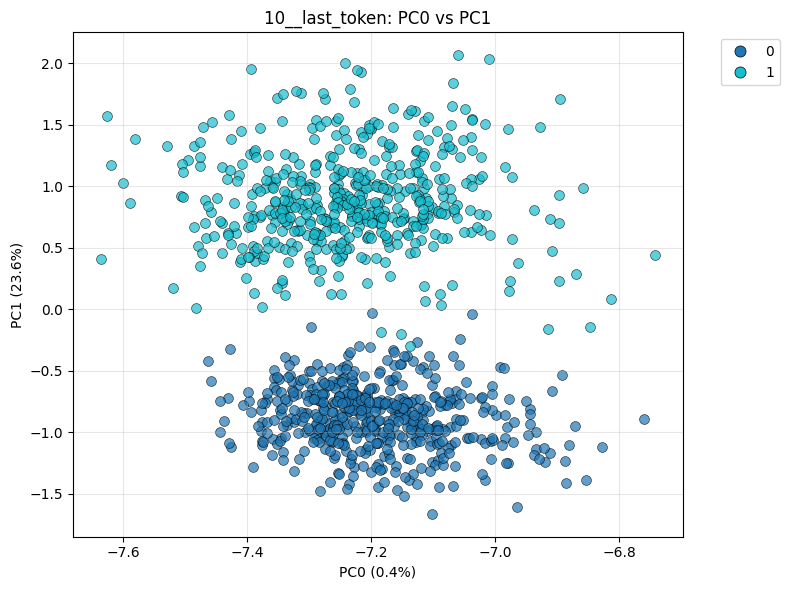

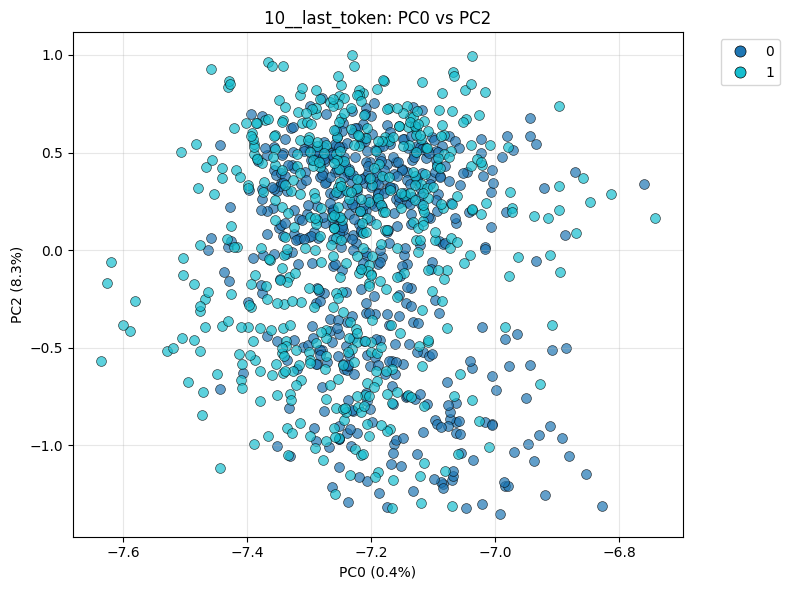

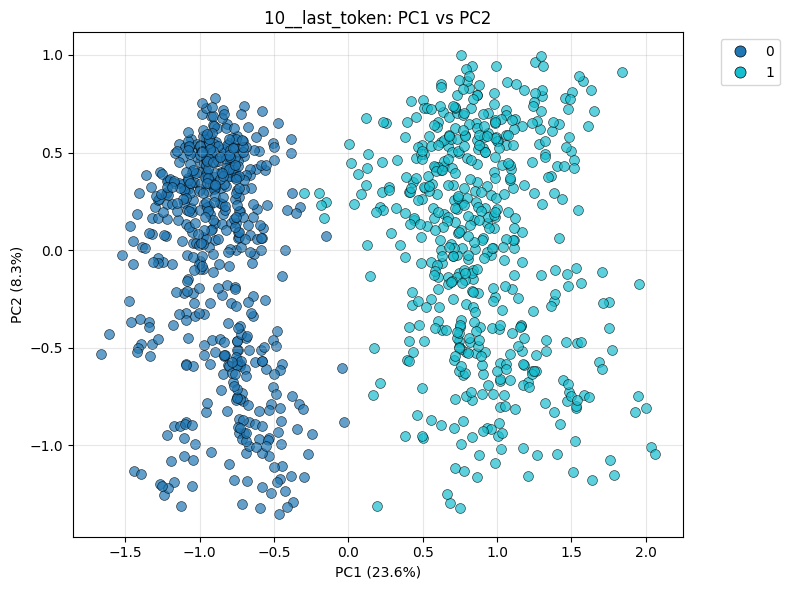


PCA analysis complete!
Results saved to: ./PCA_results_answer_position/plots


In [29]:
from causalab.experiments.jobs.collect_PCA import collect_and_compute_PCA

# Run PCA analysis
# We'll use answer_position as labels to see if the model separates
# examples based on which position contains the correct answer

result = collect_and_compute_PCA(
    interchange_targets=targets,
    data=dataset,
    pipeline=pipeline,
    labels=labels_answer_position,
    component_tuples=[(0, 1), (0, 2), (1, 2)],
    n_components=512,
    normalize=False,
    output_dir="./PCA_results_answer_position",
    verbose=True,
)

print(f"\nPCA analysis complete!")
print(f"Results saved to: {result['output_paths'].get('plots_dir', 'N/A')}")

## Interpreting the PCA Results

The scatter plots show how samples are distributed in PCA space at each layer. Look for:

1. **Separation by label** - If points with different labels form distinct clusters, the model encodes that information linearly
2. **Layer progression** - How does the separation change from early to late layers?
3. **Variance explained** - The axis labels show what percentage of variance each PC captures

If you see clear separation by `answer_position` at later layers, this suggests the model has learned to represent which position contains the correct answer - consistent with our causal model hypothesis.

## Examine Explained Variance

Let's look at how much variance each principal component explains. This tells us about the structure of the activation space.

In [30]:
# Show explained variance for each target
for key_str, svd_result in result["svd_results_by_target"].items():
    explained_var = svd_result["explained_variance_ratio"]
    cumulative_var = sum(explained_var)

    print(f"\n{key_str}:")
    print(
        f"  Total variance explained by {len(explained_var)} components: {cumulative_var:.1%}"
    )
    print(f"  Top 3 components:")
    for i, var in enumerate(explained_var[:3]):
        print(f"    PC{i}: {var:.1%}")


10__last_token:
  Total variance explained by 512 components: 99.8%
  Top 3 components:
    PC0: 0.4%
    PC1: 23.6%
    PC2: 8.3%


## 3D Visualization

For richer exploration, we can visualize PCA results in 3D. This shows three principal components simultaneously, which can reveal structure that isn't visible in 2D projections.

Use 3-tuples in `component_tuples` to generate 3D scatter plots. The plots are interactive in Jupyter - you can rotate them to explore the data from different angles.

3D visualization for 10__last_token:


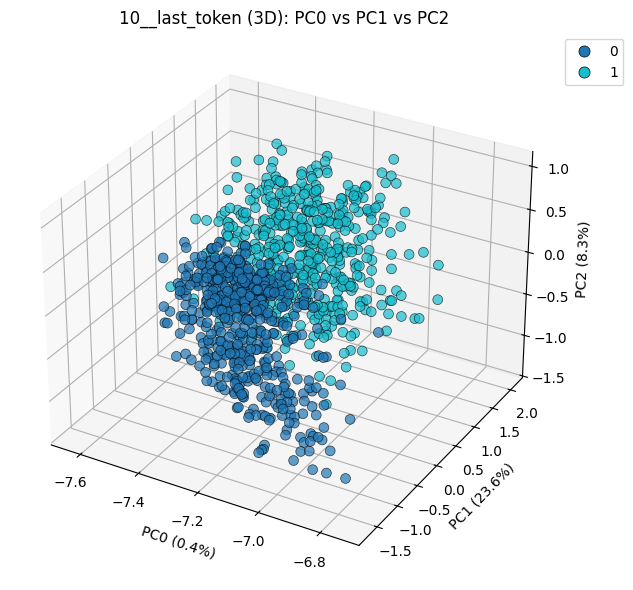

In [31]:
from causalab.experiments.visualizations.pca_scatter import plot_pca_scatter

# Get one of the targets to visualize in 3D
key = list(result["features_by_target"].keys())[0]

print(f"3D visualization for {key}:")
plot_pca_scatter(
    features=result["features_by_target"][key],
    svd_result=result["svd_results_by_target"][key],
    labels=labels_answer_position,
    component_tuples=[(0, 1, 2)],
    title=f"{key} (3D)",
)

## Dual-Label Encoding: Color + Shape

Sometimes we want to visualize **two** categorical variables simultaneously. The `shape_labels` parameter lets us encode a second variable using marker shapes, while the primary `labels` controls color.

This is useful for:
- Seeing how two variables interact in the representation space
- Identifying whether clusters are explained by one variable or both
- Comparing within-group vs between-group structure

**Best practice**: Use color for variables with many categories (like answer letters A-Z) and shape for variables with few categories (like binary position 0/1), since there are only 10 distinct marker shapes available.

Answer letters (for color): 26 unique values
Answer positions (for shape): {0, 1}

2D visualization with color (answer letter) + shape (position):


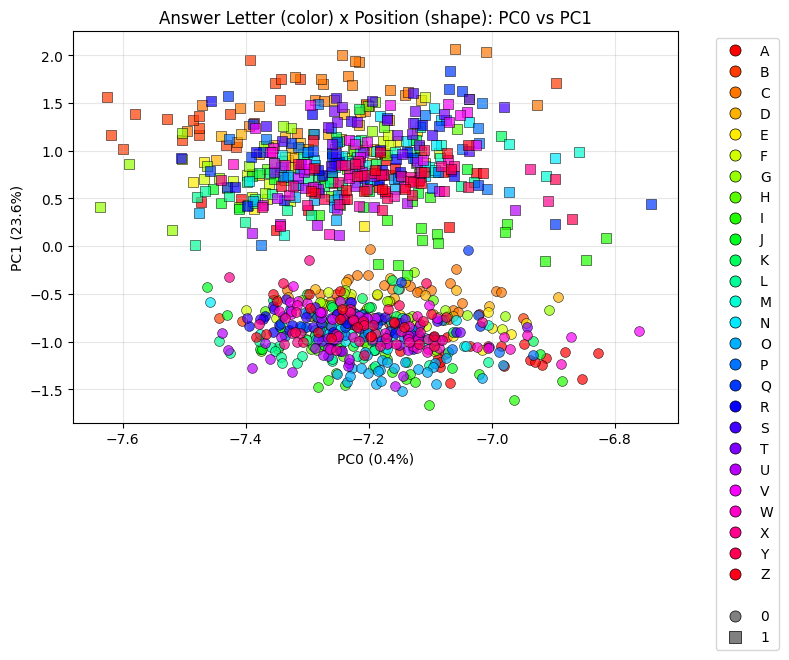

In [32]:
# Dual-label encoding: color by answer letter, shape by position
# - Color: answer letter (A-Z) - many categories, good for color
# - Shape: answer_position (0 or 1) - binary, good for shape (only 2 markers needed)

print(f"Answer letters (for color): {len(set(labels_answer))} unique values")
print(f"Answer positions (for shape): {set(labels_answer_position)}")

# 2D plot with dual labels: color=answer letter, shape=position
print("\n2D visualization with color (answer letter) + shape (position):")
plot_pca_scatter(
    features=result["features_by_target"][key],
    svd_result=result["svd_results_by_target"][key],
    labels=labels_answer,  # Color by answer letter (A-Z)
    shape_labels=labels_answer_position,  # Shape by position (0 or 1)
    component_tuples=[(0, 1)],
    title="Answer Letter (color) x Position (shape)",
)

3D visualization with color (answer letter) + shape (position):


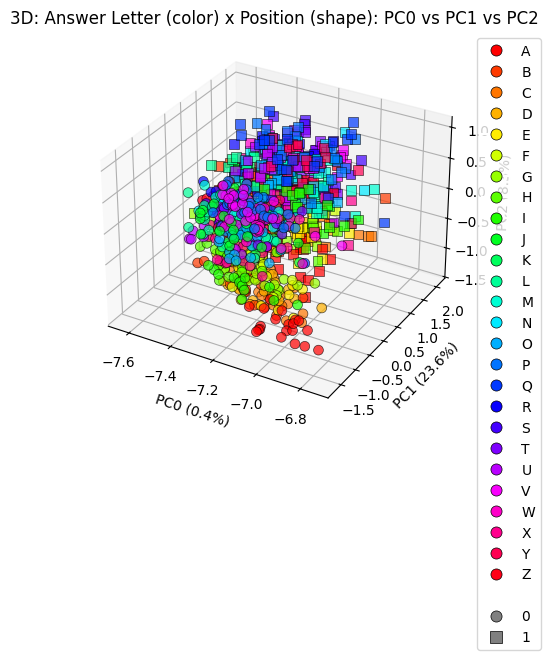

In [33]:
# 3D plot with dual labels: color=answer letter, shape=position
print("3D visualization with color (answer letter) + shape (position):")
plot_pca_scatter(
    features=result["features_by_target"][key],
    svd_result=result["svd_results_by_target"][key],
    labels=labels_answer,
    shape_labels=labels_answer_position,
    component_tuples=[(0, 1, 2)],
    title="3D: Answer Letter (color) x Position (shape)",
)

## Stack Mode: Comparing Multiple Units in Shared PCA Space

So far we've analyzed each layer separately. But what if we want to compare activations **across** multiple model units in a shared PCA space?

The `combine_mode="stack"` option lets us do this. Instead of concatenating features from different units (which creates a joint feature space), stacking treats each unit's activations as separate samples in a **shared** feature space.

This is useful for:
- Comparing attention heads to see which ones cluster together
- Visualizing how representations differ across layers
- Identifying which units encode similar information

In [34]:
# Build a target with multiple layers for stack mode comparison
# Using "one_target_all_units" mode puts all units into a single target
stacked_targets = build_residual_stream_targets(
    pipeline=pipeline,
    layers=[0, 5, 10, 15],
    token_positions=[last_token_pos],
    mode="one_target_all_units",  # All units in one target
)

print(f"Built {len(stacked_targets)} target for stack mode:")
for key in stacked_targets:
    target = stacked_targets[key]
    num_units = len(target.flatten())
    print(f"  {key}: {num_units} model units")

Built 1 target for stack mode:
  ('all',): 4 model units


Processing batches:   0%|          | 0/32 [00:00<?, ?it/s]

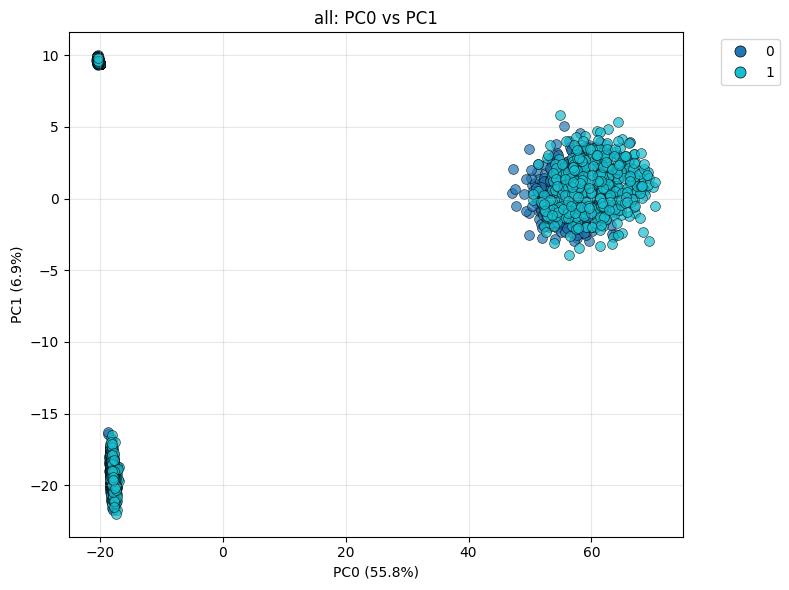

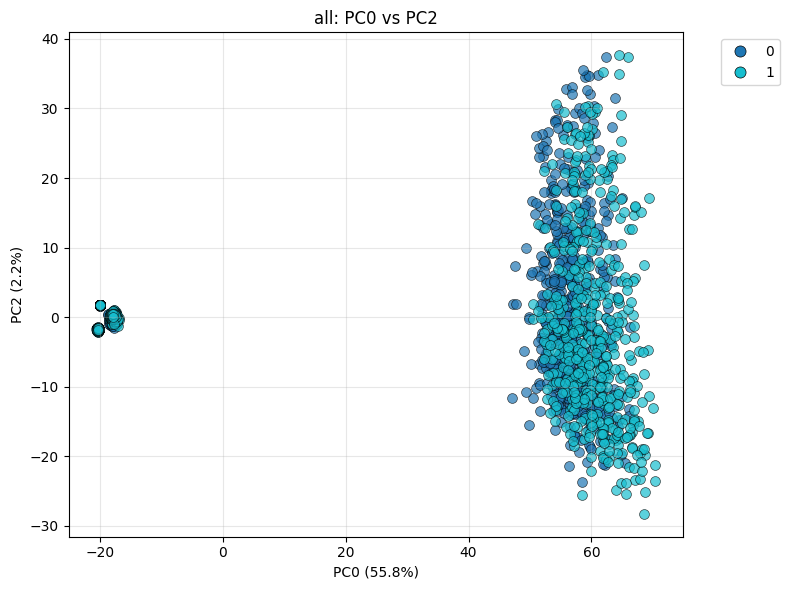

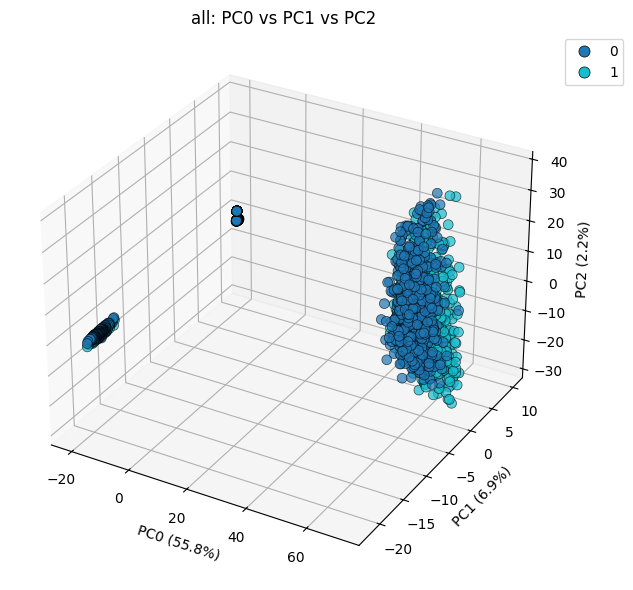


Stack mode PCA complete!
Features shape: torch.Size([4096, 2048])


In [35]:
# Run PCA with stack mode
result_stacked = collect_and_compute_PCA(
    interchange_targets=stacked_targets,
    data=dataset,
    pipeline=pipeline,
    labels=labels_answer_position,
    component_tuples=[(0, 1), (0, 2), (0, 1, 2)],
    combine_mode="stack",
    n_components=10,
    output_dir="./PCA_results_stacked",
    verbose=True,
)

print(f"\nStack mode PCA complete!")
print(f"Features shape: {list(result_stacked['features_by_target'].values())[0].shape}")

Created 4 unit labels (will be auto-replicated to match features)
Visualizing stacked features colored by layer:


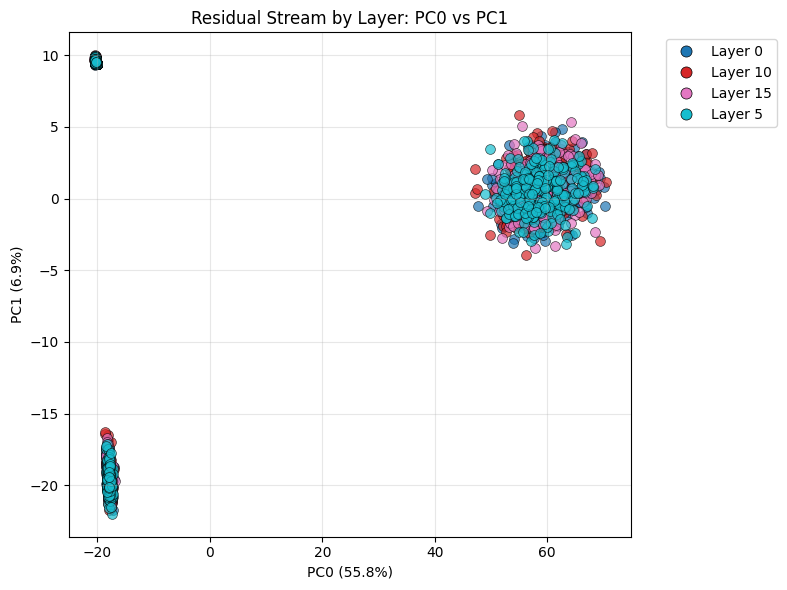

In [36]:
# Visualize the stacked features, colored by UNIT (layer) instead of sample label
# This shows how different layers cluster in the shared PCA space

# Get the target and create unit labels directly from the ModelUnits
key_tuple = list(stacked_targets.keys())[0]
key_str = list(result_stacked["features_by_target"].keys())[0]
units = stacked_targets[key_tuple].flatten()

# Create labels from units - these will be auto-replicated by plot_pca_scatter
unit_labels = [f"Layer {u.layer}" for u in units]

print(
    f"Created {len(unit_labels)} unit labels (will be auto-replicated to match features)"
)
print("Visualizing stacked features colored by layer:")
plot_pca_scatter(
    features=result_stacked["features_by_target"][key_str],
    svd_result=result_stacked["svd_results_by_target"][key_str],
    labels=unit_labels,
    component_tuples=[(0, 1)],
    title="Residual Stream by Layer",
)

3D visualization of stacked features by layer:


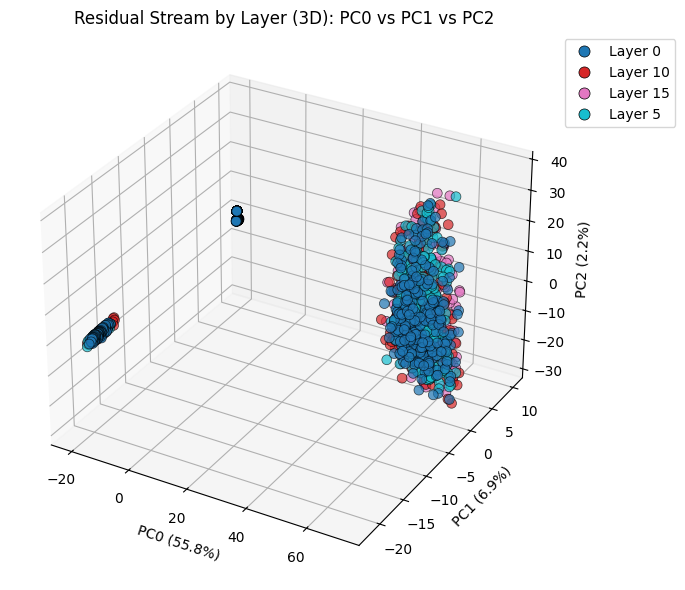

In [37]:
# 3D version of the layer comparison
print("3D visualization of stacked features by layer:")
plot_pca_scatter(
    features=result_stacked["features_by_target"][key_str],
    svd_result=result_stacked["svd_results_by_target"][key_str],
    labels=unit_labels,
    component_tuples=[(0, 1, 2)],
    title="Residual Stream by Layer (3D)",
)

Stacked features: color=layer, shape=answer_position


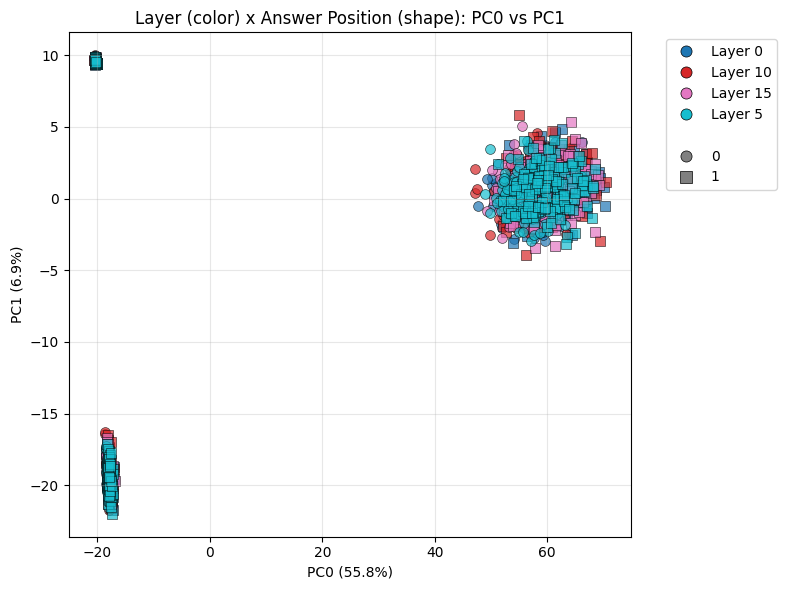

In [38]:
# Stack mode with dual labels: color by layer, shape by answer_position
# This reveals whether each layer separates by answer_position

print("Stacked features: color=layer, shape=answer_position")
plot_pca_scatter(
    features=result_stacked["features_by_target"][key_str],
    svd_result=result_stacked["svd_results_by_target"][key_str],
    labels=unit_labels,
    shape_labels=labels_answer_position,
    component_tuples=[(0, 1)],
    title="Layer (color) x Answer Position (shape)",
)

Visualizing stacked features colored by answer_position:


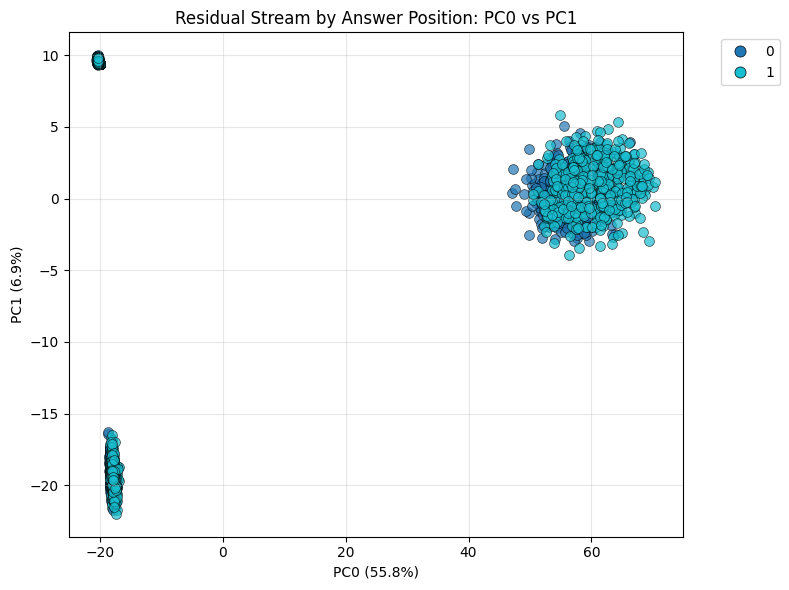

In [39]:
# We can also visualize the same stacked features colored by sample label
# Labels are auto-replicated to match the stacked features

print("Visualizing stacked features colored by answer_position:")
plot_pca_scatter(
    features=result_stacked["features_by_target"][key_str],
    svd_result=result_stacked["svd_results_by_target"][key_str],
    labels=labels_answer_position,
    component_tuples=[(0, 1)],
    title="Residual Stream by Answer Position",
)

# Takeaways

This notebook demonstrated **unsupervised** feature analysis using PCA:

1. **PCA reveals structure** - By projecting activations onto principal components, we can visualize how the model organizes information

2. **Labels provide interpretation** - Coloring points by causal variable values lets us see whether the model's representations align with our hypothesized variables

3. **Layer progression matters** - Comparing PCA plots across layers shows how information is transformed through the network

4. **Stack mode for comparison** - Using `combine_mode="stack"` lets us compare multiple model units in a shared PCA space, revealing how representations cluster across layers or attention heads

5. **3D visualization** - Using 3-tuples in `component_tuples` creates interactive 3D plots for richer exploration

6. **Dual-label encoding** - The `shape_labels` parameter lets you encode two variables (color + shape) to understand their interaction

7. **Complements supervised methods** - PCA is exploratory; it can generate hypotheses that are then tested with DAS or DBM

**Key insight**: If you see clear clustering by a causal variable in PCA space, this suggests the variable is encoded in a relatively low-dimensional subspace - making it a good candidate for DAS to learn an aligned subspace.

# From PCA to Supervised Learning: PCA-Initialized DAS

The previous sections showed how PCA can reveal structure in activations. But PCA is **unsupervised** - it finds directions of maximum variance, which may or may not correspond to causally relevant features.

We can combine the best of both worlds by using PCA to **initialize** the subspace for Distributed Alignment Search (DAS). Instead of starting DAS from a random orthogonal basis, we initialize it with the principal components from PCA. This can:

1. **Speed up convergence** - Starting closer to a good solution
2. **Improve results** - PCA directions may already capture relevant structure
3. **Enable comparison** - See how much DAS refines the PCA solution

The workflow is:
1. Run PCA to get rotation matrices for each model unit
2. Initialize `SubspaceFeaturizer` with the PCA rotation
3. Run DAS training - units with pre-initialized featurizers are automatically preserved

## Generate Filtered Datasets for DAS Training

DAS requires **filtered** datasets where the model answers correctly on both base and source examples. This ensures we're studying the model's actual computation, not its failure modes.

In [40]:
from causalab.experiments.filter import filter_dataset
from causalab.tasks.MCQA.counterfactuals import same_symbol_different_position


# Define the metric for filtering (model output matches causal model prediction)
def checker(neural_output: dict[str, str], causal_output: str) -> bool:
    return (
        causal_output in neural_output["string"]
        or neural_output["string"] in causal_output
    )


# Generate and filter training dataset
# We use same_symbol_different_position which varies the answer_position variable
train_size = 64
train_dataset = [same_symbol_different_position() for _ in range(train_size)]
filtered_train = filter_dataset(
    dataset=train_dataset,
    pipeline=pipeline,
    causal_model=causal_model,
    metric=checker,
    batch_size=128,
)

# Generate and filter test dataset
test_dataset = [same_symbol_different_position() for _ in range(train_size)]
filtered_test = filter_dataset(
    dataset=test_dataset,
    pipeline=pipeline,
    causal_model=causal_model,
    metric=checker,
    batch_size=128,
)

# Save to disk (required by train_interventions)
train_path = "./temp_das_train"
test_path = "./temp_das_test"
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
save_counterfactual_examples(filtered_train, train_path)
save_counterfactual_examples(filtered_test, test_path)

print(f"Training set: {len(filtered_train)} examples (filtered from {train_size})")
print(f"Test set: {len(filtered_test)} examples (filtered from {train_size})")

Computing base outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Saving the dataset (0/1 shards):   0%|          | 0/57 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Training set: 57 examples (filtered from 64)
Test set: 54 examples (filtered from 64)


## Initialize Featurizers from PCA

Now we use the PCA results to initialize `SubspaceFeaturizer` instances on each model unit. The key is the `svd_results_by_unit` dictionary returned by `collect_and_compute_PCA`, which contains the rotation matrix for each unit keyed by `model_unit.id`.

In [52]:
from causalab.neural.featurizers import SubspaceFeaturizer

# The PCA result contains svd_results_by_unit keyed by model_unit.id
svd_results_by_unit = result["svd_results_by_unit"]

print(f"SVD results available for {len(svd_results_by_unit)} units:")
for unit_id in svd_results_by_unit:
    rotation_shape = svd_results_by_unit[unit_id]["rotation"].shape
    print(f"  {unit_id}: rotation shape {rotation_shape}")

n_features = 2
# Initialize featurizers from PCA on each target's units
for key, target in targets.items():
    for unit in target.flatten():
        # Get the PCA rotation matrix for this unit
        rotation = svd_results_by_unit[unit.id]["rotation"]

        # Create a SubspaceFeaturizer initialized with PCA
        # trainable=True allows DAS to refine the subspace
        featurizer = SubspaceFeaturizer(
            rotation_subspace=rotation[:, :n_features],
            trainable=True,
            id="PCA_init",
        )
        unit.set_featurizer(featurizer)

print(f"\n✓ Initialized {len(targets)} targets with PCA-based featurizers")

SVD results available for 1 units:
  ResidualStream(Layer-10,block_output,Token-last_token): rotation shape torch.Size([2048, 512])

✓ Initialized 1 targets with PCA-based featurizers


## Train DAS with PCA Initialization

Now we run DAS training using `train_DAS`. Since our featurizers have a non-"null" id ("PCA_init"), they will be automatically preserved instead of being overwritten with random ones.

We're targeting the `answer_position` variable, which should be well-localized in the later layers based on our PCA visualizations showing separation by answer_position.

Training targets:   0%|          | 0/1 [00:00<?, ?it/s]

Training targets: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


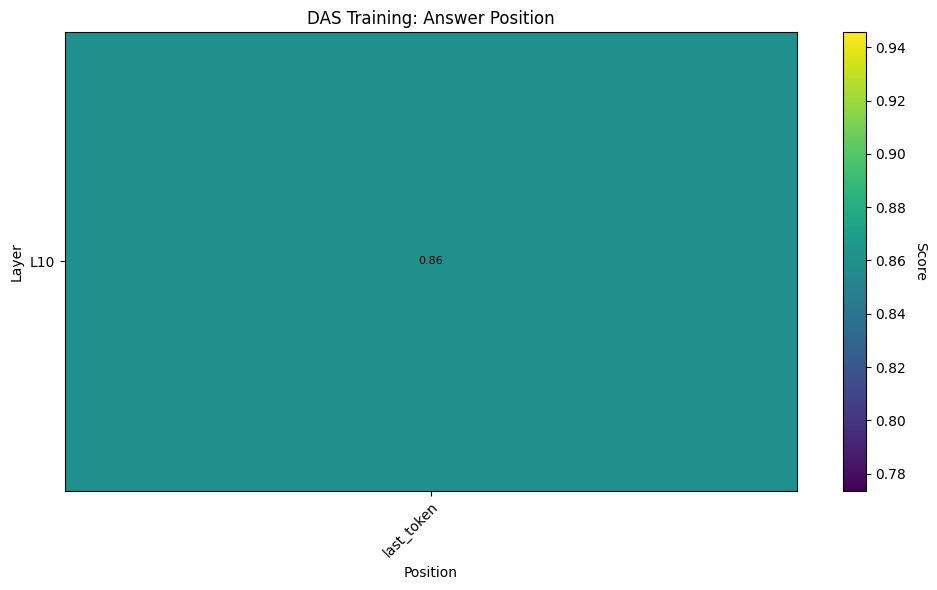

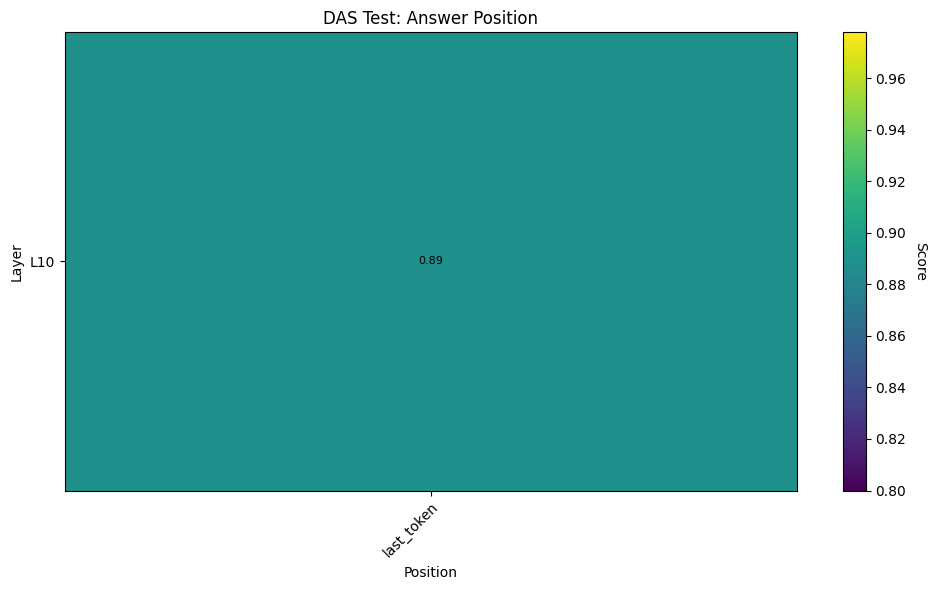


DAS WITH PCA INITIALIZATION - RESULTS
Best train score: 0.860
Best test score: 0.889

Per-layer results:
  Layer 10: train=0.860, test=0.889


In [53]:
from causalab.experiments.jobs.DAS_grid import train_DAS
from causalab.experiments.configs.train_config import PartialExperimentConfig

das_config: PartialExperimentConfig = {
    # Training parameters
    "train_batch_size": 32,
    "evaluation_batch_size": 64,
    "training_epoch": 20,
    "init_lr": 0.001,
    # DAS-specific parameters
    "DAS": {
        "n_features": n_features,
    },
}

# Train DAS with PCA-initialized featurizers using the job interface
das_result = train_DAS(
    causal_model=causal_model,
    interchange_targets=targets,
    train_dataset_path=train_path,
    test_dataset_path=test_path,
    pipeline=pipeline,
    target_variable_group=("answer_position",),
    output_dir="./DAS_pca_init_results",
    metric=checker,
    config=das_config,
    verbose=True,
)

print("\n" + "=" * 60)
print("DAS WITH PCA INITIALIZATION - RESULTS")
print("=" * 60)
print(f"Best train score: {das_result['metadata']['train_max_score']:.3f}")
print(f"Best test score: {das_result['metadata']['test_max_score']:.3f}")
print("\nPer-layer results:")
for key, score in das_result["test_scores"].items():
    train_score = das_result["train_scores"][key]
    print(f"  Layer {key[0]:2d}: train={train_score:.3f}, test={score:.3f}")

## Summary: PCA → DAS Workflow

This section demonstrated the complete workflow for using PCA to initialize DAS:

1. **Collect features and compute PCA** using `collect_and_compute_PCA()`, which returns `svd_results_by_unit` keyed by `model_unit.id`

2. **Initialize featurizers** by looping over targets and setting `SubspaceFeaturizer` with `rotation_subspace=rotation` from the PCA results

3. **Train DAS** using `train_DAS()` - units with pre-initialized featurizers (id != "null") are automatically preserved

The benefits of this approach:
- **Warm start**: DAS begins from a subspace that already captures variance in activations
- **Interpretable**: The initial directions have clear meaning (principal components)
- **Comparable**: You can compare PCA-initialized vs random-initialized DAS to see how much the causal supervision improves the subspace

# PCA-Initialized DBM: Finding Causally Relevant Principal Components

We can also use PCA to initialize **DBM** (Desiderata-Based Masking). While DAS learns to refine the subspace, DBM learns **which features to mask** during interchange interventions.

With a PCA-initialized featurizer:
- Standard DBM masks raw activation dimensions (e.g., 2048 dims)
- PCA-initialized DBM masks **principal components** (e.g., 10 components)

This answers: "Which principal components carry the causal variable?"

## Build Target for DBM

DBM requires all units in a single target (`mode="one_target_all_units"`) so it can learn a joint mask across all layers. We'll reuse the same layers [0, 5, 10, 15] from our PCA analysis.

In [54]:
# Build a single target containing all units for DBM
dbm_targets = build_residual_stream_targets(
    pipeline=pipeline,
    layers=layers_to_analyze,  # [0, 5, 10, 15]
    token_positions=[last_token_pos],
    mode="one_target_all_units",  # All units in one target for DBM
)

print(f"Built DBM target:")
for key, target in dbm_targets.items():
    units = target.flatten()
    print(f"  {key}: {len(units)} units")
    for unit in units:
        print(f"    - {unit.id}")

Built DBM target:
  ('all',): 1 units
    - ResidualStream(Layer-10,block_output,Token-last_token)


## Initialize PCA Featurizers for DBM

We initialize `SubspaceFeaturizer` from PCA with `trainable=False` - the PCA basis stays fixed, and DBM learns which components to mask.

In [55]:
# Initialize featurizers from PCA for DBM
# We reuse svd_results_by_unit from the earlier PCA run

for key, target in dbm_targets.items():
    for unit in target.flatten():
        # Get the PCA rotation matrix for this unit
        rotation = svd_results_by_unit[unit.id]["rotation"]

        # Create SubspaceFeaturizer with fixed PCA basis
        # trainable=False keeps the PCA directions fixed
        # DBM will learn which of these directions to mask
        featurizer = SubspaceFeaturizer(
            rotation_subspace=rotation,
            trainable=False,  # Fixed PCA basis - DBM learns masks only
            id="PCA_for_DBM",
        )
        unit.set_featurizer(featurizer)

        print(f"  {unit.id}: {rotation.shape[1]} PCA components")

print(f"\n✓ Initialized DBM target with PCA featurizers")

  ResidualStream(Layer-10,block_output,Token-last_token): 512 PCA components

✓ Initialized DBM target with PCA featurizers


## Train DBM in PCA Space

Now we train DBM with `train_DBM_feature_masks`, which uses `tie_masks=False` to get separate masks for each PCA component. The function automatically generates a feature count heatmap visualization.

Training targets:   0%|          | 0/1 [00:00<?, ?it/s]

Training targets: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]
/mnt/polished-lake/home/atticus/github/causalab-internal-boundlessDAS/causalab/experiments/visualizations/utils.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


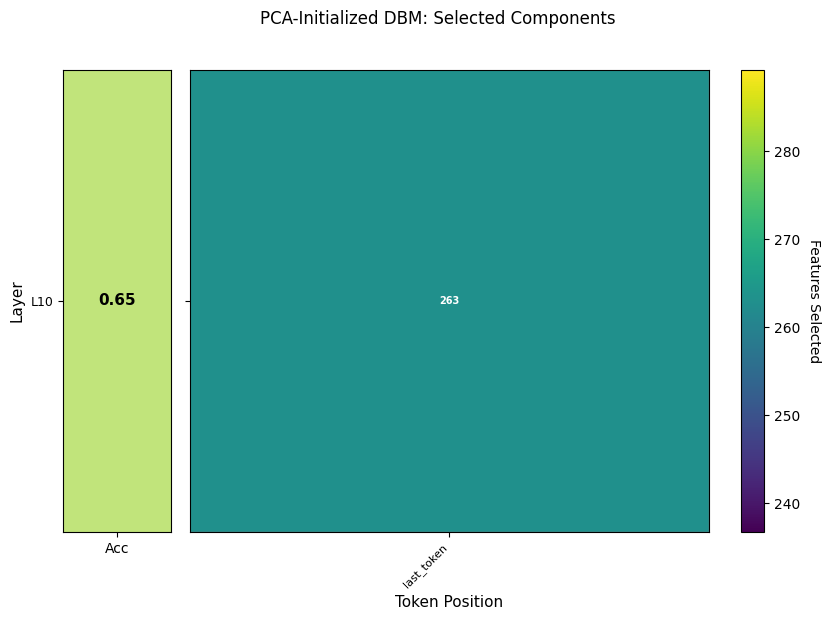


DBM WITH PCA INITIALIZATION - RESULTS
Train score: 0.544
Test score: 0.648


In [56]:
from causalab.experiments.jobs.DBM_feature_masks_grid import train_DBM_feature_masks
from causalab.experiments.configs.train_config import PartialExperimentConfig

# Train DBM with PCA-initialized featurizers
# The featurizers are already set on the units, so train_DBM_feature_masks
# will respect them and learn masks over the PCA components
dbm_target = dbm_targets[("all",)]

# Configuration for DBM training - modify these values to experiment
dbm_config: PartialExperimentConfig = {
    # Training parameters
    "train_batch_size": 32,
    "evaluation_batch_size": 64,
    "training_epoch": 20,
    "init_lr": 0.001,
    # Masking-specific parameters
    "masking": {
        "regularization_coefficient": 1e-4,  # L1 sparsity regularization
        "temperature_annealing_fraction": 0.5,  # Fraction of steps to anneal temperature
        "temperature_schedule": (1.0, 0.001),  # (start_temp, end_temp)
    },
}

dbm_result = train_DBM_feature_masks(
    causal_model=causal_model,
    interchange_target=dbm_target,
    train_dataset_path=train_path,
    test_dataset_path=test_path,
    pipeline=pipeline,
    target_variable_group=("answer_position",),
    output_dir="./DBM_pca_init_results",
    metric=checker,
    config=dbm_config,
    verbose=True,
    title="PCA-Initialized DBM: Selected Components",
)

print("\n" + "=" * 60)
print("DBM WITH PCA INITIALIZATION - RESULTS")
print("=" * 60)
print(f"Train score: {dbm_result['train_score']:.3f}")
print(f"Test score: {dbm_result['test_score']:.3f}")

## Visualize Selected PCA Components

The training automatically generated a heatmap showing which PCA components were selected at each layer. Let's display it along with some additional analysis.

Generated heatmap: ./DBM_pca_init_results/heatmaps/answer_position_features.png



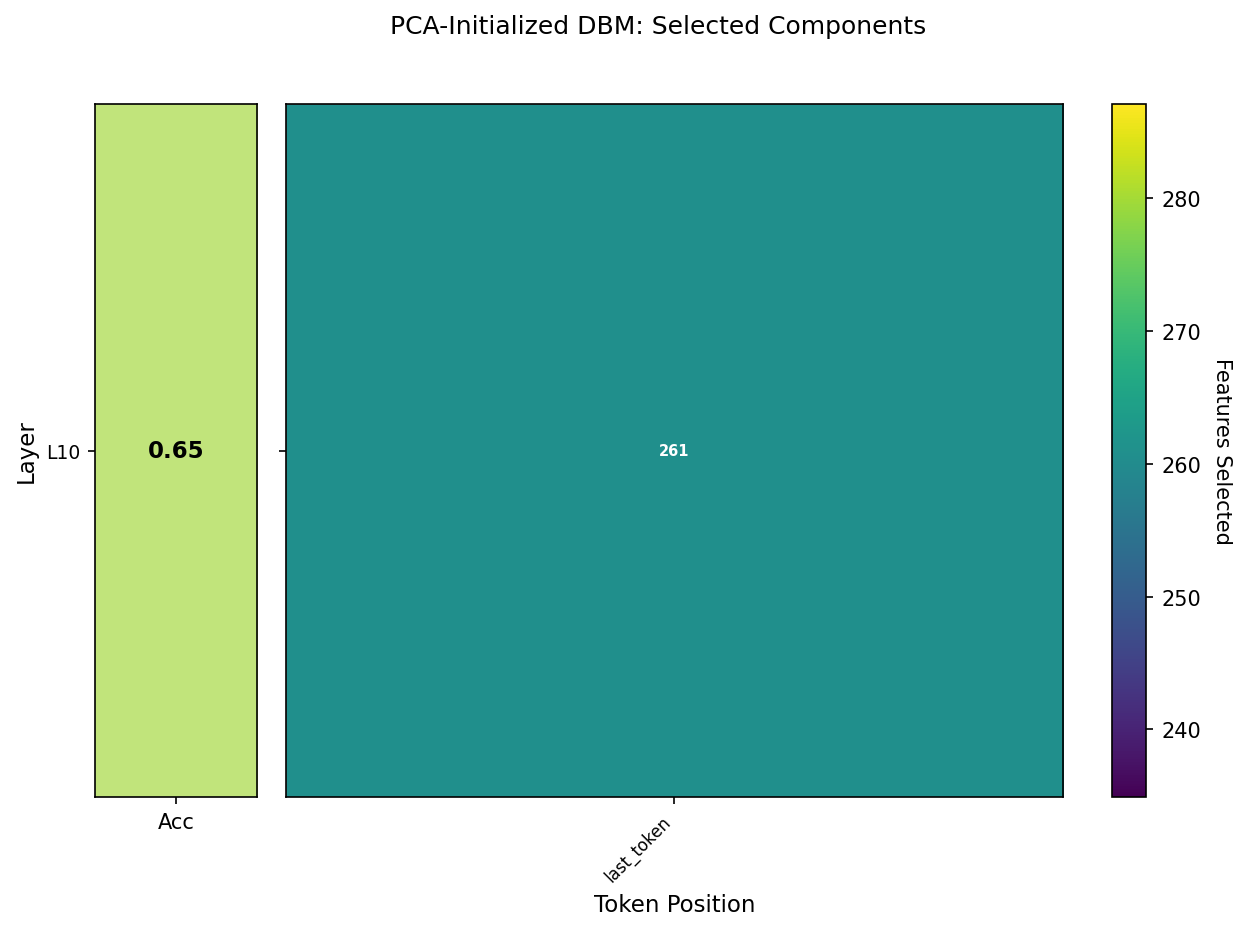


Selected PCA components by layer:

ResidualStream(Layer-10,block_output,Token-last_token):
  Selected components: [0, 1, 2, 3, 4, 6, 7, 9, 10, 14, 15, 17, 18, 22, 23, 24, 25, 27, 28, 31, 32, 36, 40, 41, 43, 44, 46, 50, 51, 52, 53, 54, 56, 59, 60, 61, 62, 63, 64, 69, 70, 74, 75, 78, 81, 83, 87, 89, 91, 93, 96, 98, 101, 107, 109, 110, 111, 112, 113, 115, 116, 119, 121, 122, 123, 124, 126, 133, 134, 136, 137, 138, 140, 145, 150, 152, 153, 154, 156, 157, 158, 161, 165, 166, 167, 168, 169, 173, 174, 175, 176, 180, 182, 185, 186, 189, 190, 192, 196, 200, 206, 207, 208, 209, 210, 212, 215, 217, 223, 224, 227, 231, 234, 235, 237, 238, 239, 240, 241, 242, 243, 247, 248, 250, 254, 257, 258, 260, 266, 267, 270, 273, 278, 280, 281, 282, 283, 284, 285, 286, 287, 290, 292, 293, 295, 298, 300, 301, 303, 304, 307, 308, 311, 313, 316, 317, 318, 319, 323, 324, 325, 326, 327, 328, 329, 334, 336, 337, 340, 341, 342, 348, 349, 350, 351, 355, 358, 360, 361, 366, 368, 370, 371, 372, 373, 374, 377, 379, 380,

In [46]:
from IPython.display import Image, display

# Display the generated heatmap
heatmap_path = dbm_result["output_paths"]["heatmap"]
print(f"Generated heatmap: {heatmap_path}\n")
display(Image(filename=heatmap_path))

# Also show detailed breakdown with variance explained
print("\n" + "=" * 50)
print("Selected PCA components by layer:")
print("=" * 50)

feature_indices = dbm_result["feature_indices"]
for unit_id, indices in feature_indices.items():
    # Get the explained variance for context
    explained_var = svd_results_by_unit[unit_id]["explained_variance_ratio"]

    print(f"\n{unit_id}:")
    if indices:
        selected_var = sum(explained_var[i] for i in indices)
        print(f"  Selected components: {indices}")
        print(f"  Variance explained by selected: {selected_var:.1%}")
    else:
        print(f"  No components selected")

## Summary: PCA + DBM Feature Masks Workflow

This section demonstrated using PCA to initialize DBM with per-feature masks:

1. **Build target** with `mode="one_target_all_units"` for DBM
2. **Initialize featurizers** with `SubspaceFeaturizer(rotation_subspace=rotation, trainable=False)`
3. **Train with `train_DBM_feature_masks`** - learns per-feature masks over PCA components and generates visualization
4. **Analyze results** to see which PCA components were selected

**Key insight**: PCA-initialized DBM finds which principal components are causally relevant. This is more interpretable than masking raw activations because:
- Each PCA component has a clear meaning (direction of variance)
- The number of components is small (e.g., 10 vs 2048)
- Selected components can be related back to the variance they explain

**API Summary**:
- `train_DBM_feature_masks`: Core function for learning per-feature masks (respects pre-initialized featurizers)
- `train_boundless_DAS`: Convenience wrapper that initializes `SubspaceFeaturizer` with trainable=True before calling `train_DBM_feature_masks`